In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.utils import resample

DATA

In [2]:
#read in all covariate data
data_all = pd.read_csv("score_val_allModalities.csv")

#read in true classes
perf = pd.read_csv("PerfMetrics.csv")

In [3]:
#explore data
display(data_all)
display(perf)

,Subject-Run,eda_hand_l_kOhms-Mean,eda_hand_l_kOhms-SD,eda_hand_l_kOhms-FPC1,eda_hand_l_kOhms-FPC2,eda_hand_l_kOhms-FPC3,ppg_finger_mV-Mean,ppg_finger_mV-SD,ppg_finger_mV-FPC1,accelerometry_forearm_r_x_mps2-Mean,...,pilot_head_yaw_deg-Skew,pilot_head_yaw_deg-Kurtosis,pilot_head_yaw_deg-FPC1,pilot_head_yaw_deg-FPC2,pilot_head_yaw_deg-FPC3,pilot_head_yaw_deg-FPC4,pilot_head_yaw_deg-FPC5,pilot_head_yaw_deg-FPC6,pilot_head_yaw_deg-FPC7,pilot_head_yaw_deg-FPC8
0,sub-cp004-run-001,63.408144,6.161920,16166.812270,11036.183470,138.091561,421.364913,16.315803,-21261.927170,9.842644,...,3.338471,12.190865,-2908.694021,693.178147,284.228522,395.263687,320.646363,170.626229,-184.257096,-14.750625
1,sub-cp004-run-002,62.697601,4.747814,1716.713384,13219.480120,814.025646,429.684663,9.946702,-21368.341010,10.964194,...,5.644197,33.000807,-2879.156131,-1144.738919,674.312994,54.117803,-69.727602,240.228419,-7.269292,405.372813
2,sub-cp004-run-003,64.627927,3.385323,1927.059961,13204.945370,829.752100,433.181051,5.360770,-21225.654530,10.997024,...,3.830337,15.682177,-2705.116150,-288.956726,354.226445,-236.090687,-273.420101,-108.109097,44.297608,-0.018426
3,sub-cp004-run-004,64.071629,6.296513,2033.513120,13303.219600,795.319883,429.882200,7.498878,-21184.045920,10.975572,...,2.344245,6.498983,-1287.276148,-2535.014111,-1508.187144,22.152972,322.143034,-216.047972,1058.699571,-383.181581
4,sub-cp004-run-005,64.613887,5.125539,15741.634390,11081.884550,185.563368,422.464261,7.196271,-19244.805020,10.369584,...,1.180001,2.394091,-1937.713451,-591.341487,1211.022684,622.466910,-702.561612,382.492473,-387.928476,-606.418132
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,sub-cp027-run-008,1424.346459,75.925855,97.324416,-15268.672460,-5020.391316,1402.270275,87.217634,3676.164996,-6.625199,...,-2.077973,5.319397,3448.129579,175.802194,-93.969367,-271.650795,-57.067446,-351.619511,155.126014,245.879991
162,sub-cp027-run-009,1119.216446,65.024516,2488.540138,-8869.409659,-4734.783801,1397.718155,111.827923,3570.113715,-6.766104,...,-0.477195,1.228072,1631.422133,75.697655,-482.813667,674.723928,-950.769829,-906.039758,-667.036145,-300.626445
163,sub-cp027-run-010,992.161984,63.696616,224.088947,-6226.532124,-2942.203978,1406.525661,101.958534,3782.880567,-6.832726,...,-0.454532,1.207071,1340.365964,1746.127788,-709.779339,439.933803,-1399.169462,149.403881,32.557086,-609.306350
164,sub-cp027-run-011,1060.919083,65.124244,-3726.847233,-7103.020761,-3206.065463,1400.164646,68.467853,3641.243896,-6.686284,...,-1.154973,2.334685,2550.701152,-225.372088,194.618113,-157.036347,650.946027,1205.149618,-407.846424,132.553644


,Subject,Date,Run,Difficulty,GlideSlope_Error,Localizer_Error,Airspeed_Error,Cumulative_Error
0,3,20210206,1,1,469.3623,525.3626,629.8226,1624.5474
1,3,20210206,2,3,602.7464,321.2262,588.0965,1512.0691
2,3,20210206,3,2,423.0488,311.9388,532.2389,1267.2265
3,3,20210206,4,4,759.4882,555.4108,613.7580,1928.6570
4,3,20210206,5,3,537.2284,474.8505,539.1892,1551.2680
...,...,...,...,...,...,...,...,...
175,27,20210722,8,2,525.6718,464.8409,1274.2105,2264.7233
176,27,20210722,9,4,622.7993,670.7377,782.2722,2075.8091
177,27,20210722,10,2,441.7870,296.8463,1160.1695,1898.8028
178,27,20210722,11,3,545.9758,440.4261,1269.8139,2256.2157


In [4]:
#align responses with covariate data
sub = [float(w[7:9]) for w in data_all['Subject-Run']]
run = [float(w[15:17]) for w in data_all['Subject-Run']]
keep = pd.DataFrame.from_dict({'Subject': sub,
                              'Run': run,
                              'Keep': np.ones(len(run))}
                             )

In [5]:
#drop regression responses
#keep only covariates aligned with observations for which we have difficulty  responses
keep_check = keep.merge(perf[['Subject','Run','Difficulty']], how='left', on=['Subject', 'Run'])

In [6]:
#get "kept" features from CogPilot model
xtrain = pd.read_csv("xtrain.csv")
sub = xtrain.columns
sub_keep = list(set(sub) & set(data_all.columns))

In [7]:
#keep selected features
data_sub = data_all[sub_keep]

In [8]:
#number of observations
n = len(keep_check)

TRAIN

In [9]:
#define RNG with set seed
rng = np.random.RandomState(seed=2022)

#initialize empty dataframe to fill with results
all_reps_coverage = pd.DataFrame(columns=['rep','method','coverage','alpha'])

In [10]:
#generate B train/test splits
#B = 25
B = 1

for b in range(B):
    #select 5 observations for test set 
    train_id = resample(range(n), n_samples=161, replace=False, random_state=rng)

    #select 20 observations for test set 
    #train_id = resample(range(n), n_samples=146, replace=False, random_state=rng)
    
    #generate train and test sets
    xtrain = data_sub.loc[data_sub.index.isin(train_id),:]
    ytrain = keep_check.loc[keep_check.index.isin(train_id),'Difficulty']
    xtest = data_sub.loc[~data_sub.index.isin(train_id),:]
    ytest = keep_check.loc[~keep_check.index.isin(train_id),'Difficulty']
    
    #combine response of interest with kept features
    train = xtrain.merge(ytrain.to_frame(), left_index=True, right_index=True)
    test = xtest.merge(ytest.to_frame(), left_index=True, right_index=True)
    
    #fit adaboost model on all kept features
    ada = AdaBoostClassifier(n_estimators=35).fit(train.drop('Difficulty', axis=1), train['Difficulty'])
    
    pival = np.zeros((len(ytest),4))
    for i in range(len(ytest)):
        for j in range(1,5):
            candidate_j = np.append(xtest.iloc[i,:].values, j)
            data_aug = train.append(pd.DataFrame(candidate_j.reshape(1,-1), columns=list(train)))
            ada_aug = AdaBoostClassifier(n_estimators=35).fit(data_aug.drop('Difficulty', axis=1), data_aug['Difficulty'])
            
            ###Sklearn's AdaBoost doesn't have a "prob" method analagous to the one in R...
            ###to estimate the probabilities of the observed reponse values being observed.
            ###To do this here, we loop through each observation...
            ###in the augmented training set to find the probabilities of each observed response.
            
            #initialize list of probabilities that we'll use later to calculate conformity scores
            probabilities = np.zeros(len(data_aug))
            #iterate through each row of dataframe
            for k in range(len(data_aug)):
                #grab the row and store it in a separate variable
                observation = data_aug.iloc[k,:]
                #record the observed difficulty for the observation
                true = observation['Difficulty'].astype(int)
                #predict the probabilities for each difficulty using predict_proba (returns a 1x4 array)
                prob_vec = ada_aug.predict_proba(pd.DataFrame(observation.drop('Difficulty')).T)
                #flatten prob_vec to a 1D array
                prob_vec = prob_vec.flatten()
                #save the probability of the observed difficulty (difficulty j is the jth entry in prob_vec)
                probabilities[k] = prob_vec[true-1]
            #generate conformity scores
            conf = 1 - probabilities
            
            #generate pi for each class/test observation combination
            pival[i,j-1] = 1 - pd.DataFrame(conf).rank(method='average').iloc[-1]/len(conf)
    
    #adaboost model output probabilities for test data
    ada_pred = ada.predict_proba(xtest)
    
    #vector of alpha values
    alpha_vec = np.arange(start=0.05, stop=1, step=0.05)
    
    coverage = np.zeros(len(alpha_vec))
    soft_coverage = np.zeros(len(alpha_vec))
    track = 0
    for alpha in alpha_vec:
        #finite sample adjustment
        alpha = 1 - math.ceil((1-alpha)*len(data_aug))/len(data_aug)
        
        #get prediction set
        conf_set_tf = pival > alpha
        #add 1 since arrays in Python are indexed starting at 0
        #variables cannot be named "set" in Python 
        conf_set = pd.DataFrame(np.argwhere(pival > alpha)+1, columns=['Row', 'Difficulty'])
        
        #choose all classes with output >= alpha
        prob_set_tf = ada_pred > alpha
        prob_set = pd.DataFrame(np.argwhere(ada_pred > alpha)+1, columns=['Row', 'Difficulty'])
        
        total_prob = ada_pred * conf_set_tf
        sum_prob = total_prob.sum(axis=1)
        
        true_vec = np.zeros(len(ytest))
        prob_vec = np.zeros(len(ytest))
        
        for k in np.arange(1,len(ytest)):
            true_vec[k-1] = ytest.iloc[k-1] in conf_set.loc[conf_set.Row==k,'Difficulty'].values
            prob_vec[k-1] = ytest.iloc[k-1] in prob_set.loc[prob_set.Row==k,'Difficulty'].values
            
        #get coverage
        coverage[track] = np.sum(true_vec)/len(ytest)
        soft_coverage[track] = np.sum(prob_vec)/len(ytest)
        
        track += 1
    
    #track coverage across all repetitions
    coverage_df = pd.DataFrame({'rep': (b+1)*np.ones(len(coverage)), 
                                'method': ['conf'] * len(coverage),
                                'coverage': coverage,
                                'alpha': 1-alpha_vec})
    soft_coverage_df = pd.DataFrame({'rep': (b+1)*np.ones(len(coverage)), 
                                     'method': ['ada'] * len(coverage),
                                     'coverage': soft_coverage,
                                     'alpha': 1-alpha_vec})
    all_reps_coverage = pd.concat([all_reps_coverage, coverage_df, soft_coverage_df], ignore_index=True)

In [11]:
#save simulation results for B=25 reps... do not run cell unless you wish to write over simulation results from R!
#all_reps_coverage.to_csv('all_reps_coverage.csv', index=False)

VISUALIZATION

In [12]:
#prediction set examples with alpha = .25
alpha = .25
alpha = 1 - math.ceil((1-alpha)*len(data_aug))/len(data_aug)

In [13]:
#conformity scores... note that these will be different than the values in the R script
pival

array([[0.54320988, 0.50308642, 0.42592593, 0.0308642 ],
       [0.61111111, 0.66666667, 0.53703704, 0.67901235],
       [0.01851852, 0.16666667, 0.42592593, 0.05555556],
       [0.55555556, 0.72222222, 0.4691358 , 0.74691358],
       [0.01851852, 0.08641975, 0.16666667, 0.41049383]])

In [14]:
#adaboost output... note that these values will be different than the values in the R script
ada_pred

array([[0.26608502, 0.2721686 , 0.25386172, 0.20788465],
       [0.29926986, 0.3058389 , 0.27868483, 0.11620641],
       [0.24544623, 0.25590583, 0.26343118, 0.23521677],
       [0.00780469, 0.40043268, 0.27117584, 0.32058679],
       [0.21876313, 0.2523642 , 0.25863059, 0.27024208]])

In [15]:
#get prediction set
conf_set_tf = pival > alpha
conf_set = pd.DataFrame(np.argwhere(pival > alpha)+1, columns=['Row', 'Difficulty'])

In [16]:
#choose all classes with output >= alpha
prob_set_tf = ada_pred > alpha
prob_set = pd.DataFrame(np.argwhere(ada_pred > alpha)+1, columns=['Row', 'Difficulty'])

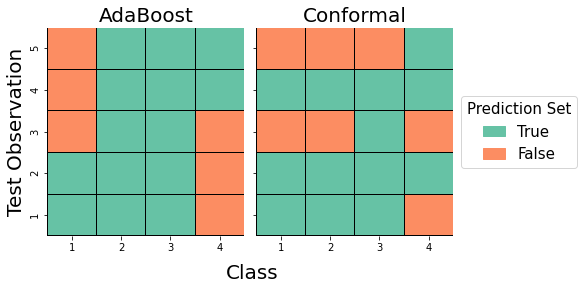

In [17]:
#visualizing prediction sets... note that this plot will be different than the plot in the R script

conf_set_df = pd.DataFrame(conf_set_tf, index=range(1,len(ytest)+1), columns=range(1,5))
prob_set_df = pd.DataFrame(prob_set_tf, index=range(1,len(ytest)+1), columns=range(1,5))
cmap = sns.mpl_palette("Set2", 2)

fig, (ax1, ax2) = plt.subplots(1,2,sharey=True, figsize=(8,3.5), constrained_layout=True)
ax1 = sns.heatmap (prob_set_df.iloc[::-1], cmap=cmap[::-1], cbar=False, ax=ax1, linewidth=0.05, linecolor='k')
ax1.set_yticks(conf_set_df.iloc[::-1].index)
ax1.set_ylabel('Test Observation', fontsize=20)
ax1.set_title('AdaBoost', fontsize=20)
ax2 = sns.heatmap(conf_set_df.iloc[::-1], cmap=cmap[::-1], cbar=False, ax=ax2, linewidth=0.05, linecolor='k')
ax2.set_title('Conformal', fontsize=20)
fig.text(0.43, -0.07, 'Class', ha='center', va='center', fontsize=20)
legend_handles = [Patch(color=cmap[0], label='True'),  # red
                  Patch(color=cmap[1], label='False')]  # green
plt.legend(handles=legend_handles, ncol=1, fontsize=15, 
           title = 'Prediction Set', title_fontsize=15,
           loc='center left', bbox_to_anchor=[1, 0.5],  handlelength=1.5)
plt.show()

In [18]:
#pull from simulation completed in R
all_reps_coverage = pd.read_csv('all_reps_coverage.csv')

In [19]:
df = all_reps_coverage
ada_coverage = df.loc[df.method=='ada']
ada_coverage = ada_coverage.groupby(['rep', 'alpha']).aggregate('first')['coverage'].unstack()
conf_coverage = df.loc[df.method=='conf']
conf_coverage = conf_coverage.groupby(['rep', 'alpha']).aggregate('first')['coverage'].unstack()

[]

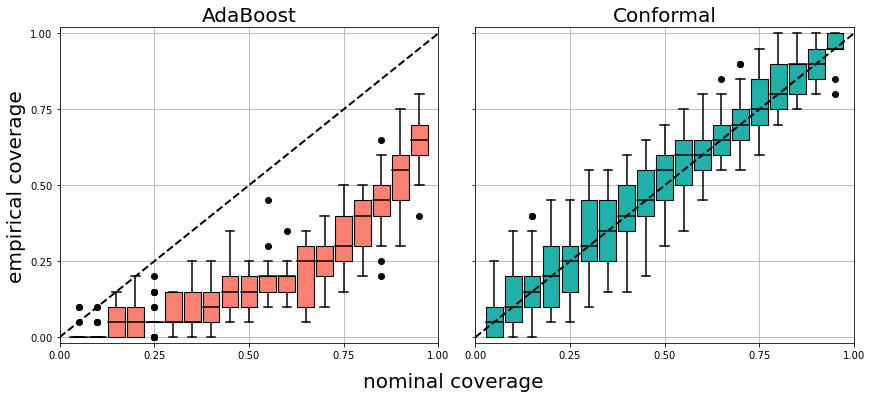

In [20]:
yticks = [0,0.25,0.5,0.75,1]
xticks = [0,10,20,30,40]
positions = np.arange(2,40,2)
position_labels = ['0.00','0.25','0.50','0.75','1.00']

fig, axs = plt.subplots(1,2,sharey=True, figsize=(12,5), constrained_layout=True)
axs[0].boxplot(ada_coverage, positions=positions, widths=1.77, patch_artist=True, zorder=5,
               medianprops={'color':'k', 'linewidth':1.5},
               boxprops={'facecolor':'salmon', 'edgecolor':'k', 'linewidth':1.1},
               whiskerprops={'color':'k', 'linewidth':1.5},
               capprops={"color": "k", "linewidth": 1.5},
               flierprops={'markerfacecolor':'k'}
               )
axs[0].set_yticks(yticks)
axs[0].set_ylim([-0.02,1.02])
axs[0].set_ylabel('empirical coverage', fontsize=20)
axs[0].set_title('AdaBoost', fontsize=20)
axs[1].boxplot(conf_coverage, positions=positions, widths=1.77, patch_artist=True, zorder=5,
               medianprops={'color':'k', 'linewidth':1.5},
               boxprops={'facecolor':'lightseagreen', 'edgecolor':'k', 'linewidth':1.1},
               whiskerprops={'color':'k', 'linewidth':1.5},
               capprops={"color": "k", "linewidth": 1.5},
               flierprops={'markerfacecolor':'k'}
               )
axs[1].set_title('Conformal', fontsize=20)
for idx in [0,1]:
    axs[idx].plot(xticks,yticks,c='k',linewidth=2,linestyle='dashed', zorder=10)
    axs[idx].set_xlim([0,40])
    axs[idx].set_xticks(xticks)
    axs[idx].set_xticklabels(position_labels)
    axs[idx].grid()
fig.text(0.52, -0.05, 'nominal coverage', ha='center', va='center', fontsize=20)
plt.plot()